In [2]:
import torch 
import torch.nn as nn

nn.functional.interpolate?

Signature:
nn.functional.interpolate(
    input: torch.Tensor,
    size: Union[int, NoneType] = None,
    scale_factor: Union[List[float], NoneType] = None,
    mode: str = 'nearest',
    align_corners: Union[bool, NoneType] = None,
    recompute_scale_factor: Union[bool, NoneType] = None,
    antialias: bool = False,
) -> torch.Tensor
Docstring:
Down/up samples the input to either the given :attr:`size` or the given
:attr:`scale_factor`

The algorithm used for interpolation is determined by :attr:`mode`.

Currently temporal, spatial and volumetric sampling are supported, i.e.
expected inputs are 3-D, 4-D or 5-D in shape.

The input dimensions are interpreted in the form:
`mini-batch x channels x [optional depth] x [optional height] x width`.

The modes available for resizing are: `nearest`, `linear` (3D-only),
`bilinear`, `bicubic` (4D-only), `trilinear` (5D-only), `area`, `nearest-exact`

Args:
    input (Tensor): the input tensor
    size (int or Tuple[int] or Tuple[int, int] or Tup

In [4]:
import numpy as np 

demo_npy = np.load('initial-depth/0VB21E007-T11@9=person_initial_back_depth.npy')
demo_npy.shape, demo_npy

((512, 320),
 array([[-8.47365987e-03, -4.68019117e-03,  5.93644043e-04, ...,
         -9.81712714e-04, -4.11396520e-03, -5.52079454e-03],
        [-7.10615073e-04, -4.07849951e-03, -1.62121153e-03, ...,
         -1.32761849e-03, -2.67021102e-03, -1.46436144e-03],
        [ 4.78488801e-04, -1.97158754e-03, -1.02091595e-04, ...,
         -6.60869176e-04, -1.40878919e-03, -1.13854418e-03],
        ...,
        [-7.95252156e-04, -1.48374855e-03, -1.25307112e-03, ...,
          7.27611550e-05, -2.03470088e-04, -1.65271189e-03],
        [-1.94801879e-03, -2.22177408e-03, -1.63685833e-03, ...,
          4.70088591e-04,  2.03738091e-04, -1.61790929e-03],
        [-4.15898208e-03,  2.09886162e-03,  1.98141890e-04, ...,
          4.87533602e-04,  1.15183217e-03,  5.73216565e-03]], dtype=float32))

In [ ]:
keypoints = np.array(datas['people'][0]['pose_keypoints_2d']).reshape((-1,3))
left_hand_keypoints = keypoints[[5,6,7],:]
right_hand_keypoints = keypoints[[2,3,4],:]


In [1]:
import cv2 
import numpy as np 
import matplotlib.pyplot as plt 
from PIL import Image

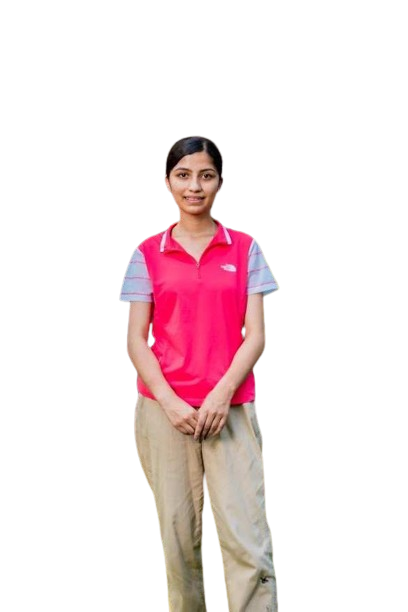

In [18]:

person = cv2.imread('pratima3.png', 0)
img = Image.open('pratima3.png')
img 


In [19]:
sobelx = cv2.Sobel(person,cv2.CV_64F,1,0,ksize=5)
sobely = cv2.Sobel(person,cv2.CV_64F,0,1,ksize=5)

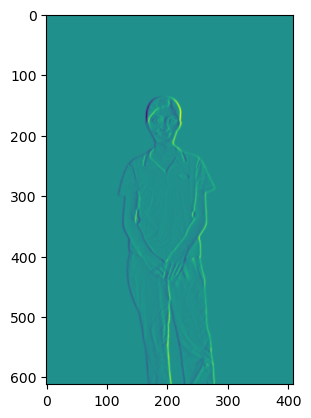

In [20]:
plt.imshow(sobelx)

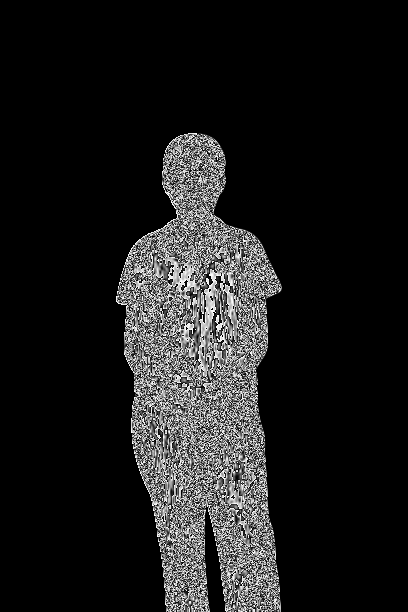

In [21]:
Image.fromarray(sobelx.astype(np.uint8))

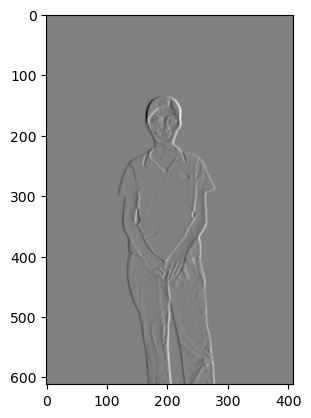

In [22]:
plt.imshow(sobelx, cmap='gray')

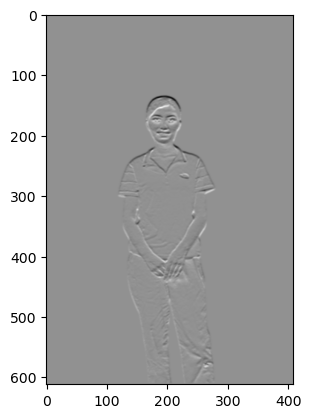

In [23]:
plt.imshow(sobely, cmap='gray')

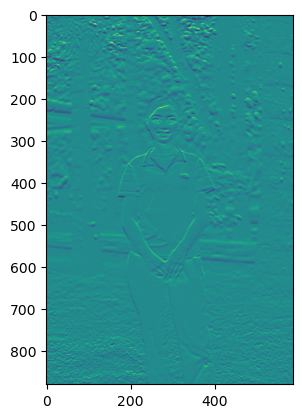

In [10]:
plt.imshow(sobely)

In [6]:
def inpaint_back(rgb, parse):
    inpaint_mask = (parse == 13).astype(np.uint8) * 255 + (parse == 10).astype(np.uint8) * 255
    person_inpainted = cv2.inpaint(rgb,inpaint_mask,3,cv2.INPAINT_TELEA)

    return person_inpainted

In [8]:
from PIL import Image 

In [9]:
parse_img = cv2.imread('label.png', 0)
rgb = np.array(Image.open('front.png'))

In [10]:
rgb_back = inpaint_back(rgb, parse_img)

In [12]:
type(rgb_back)

numpy.ndarray

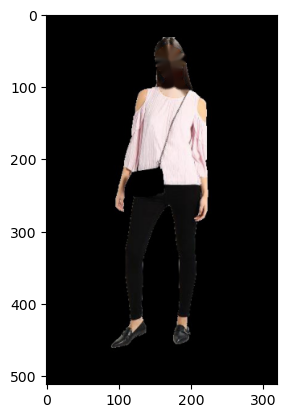

In [13]:
plt.imshow(rgb_back)

In [14]:
def depth2point(fd, bd, rgb, rgb_back, parse_shape=None, label='gt', out_fn=None):
    if label=='gt':
        fd_m = (fd > 0).astype(np.float32)
        fd = -1.0 * (2.0 * fd - 1.0) # --> world
        fd = fd * fd_m
        if parse_shape is not None:
            fd = fd * parse_shape
        bd = np.flip(bd,axis=1)
        bd_m = (bd > 0).astype(np.float32)
        bd = 2.0 * bd - 1.0 # --> world
        bd = bd * bd_m
        if parse_shape is not None:
            bd = bd * parse_shape
    elif label == 'pred':
        if parse_shape is not None:
            fd = fd * parse_shape
            bd = bd * parse_shape
    else:
        print('ERROR: label must be gt/pred!')
    points = []
    for h in range(512):
        for w in range(320):
            if fd[h, w] == 0.: continue
            color = rgb[h, w]
            Z = fd[h,w]
            X = (w + 95) / 256 - 1
            Y = (512 - 1 - h) / 256 - 1
            points.append("%f %f %f %d %d %d\n" % (X, Y, Z, color[0], color[1], color[2]))
    for h in range(512):
        for w in range(320):
            if bd[h, w] == 0.: continue
            color = rgb_back[h, w]
            Z = bd[h,w]
            X = (w + 95) / 256 - 1
            Y = (512 - 1 - h) / 256 - 1
            points.append("%f %f %f %d %d %d\n" % (X, Y, Z, color[0], color[1], color[2]))

    return points 

In [15]:

def dilate_rgb(newdepth, pix):
    for _ in range(pix):
        d1 = newdepth[3:, :, :] # down
        d2 = newdepth[:-3, :, :] # up
        d3 = newdepth[:, 3:, :] # right
        d4 = newdepth[:, :-3, :] # left
        newdepth[:-3, :,:] = np.where(newdepth[:-3,:,:] > 0, newdepth[:-3, :,:], d1)
        newdepth[3:, :,:] = np.where(newdepth[3:,:,:] > 0, newdepth[3:, :,:] , d2)
        newdepth[:,:-3,:] = np.where(newdepth[:,:-3,:] > 0, newdepth[:, :-3,:], d3)
        newdepth[:, 3:,:] = np.where(newdepth[:,3:,:] > 0, newdepth[:,3:,:], d4)

    return newdepth

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import cv2 

In [2]:
fd = np.load('front_depth.npy')
bd = np.load('back_depth.npy')
fd.shape, bd.shape 

((512, 320), (512, 320))

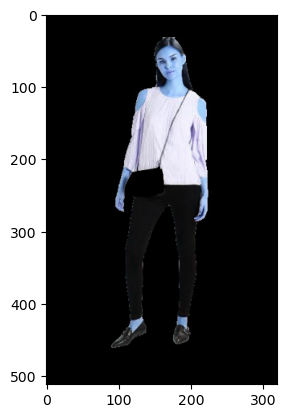

In [3]:
img = cv2.imread('front.png')
plt.imshow(img)

In [4]:
img.shape 

(512, 320, 3)

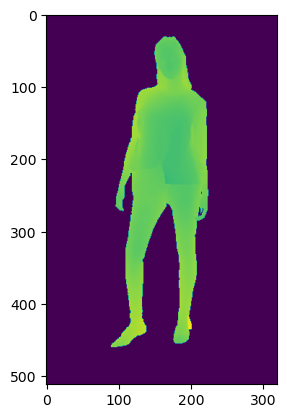

In [5]:
plt.imshow(fd)

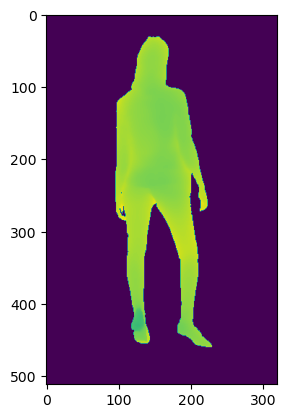

In [6]:
plt.imshow(bd)

In [8]:
bd_ = np.load('back_depth.npy')
fd_ = np.load('front_depth.npy')
bd_.shape, fd_.shape  

((512, 320), (512, 320))

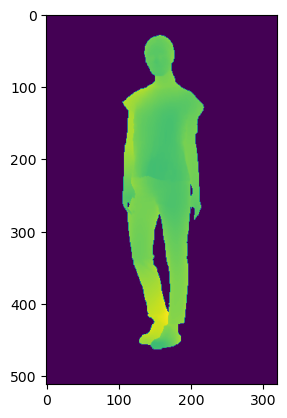

In [9]:
plt.imshow(fd_)

In [53]:
fd[:5], bd[:5]

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32))

In [54]:
fd = fd-0.02 
fd[:5]

array([[-0.02, -0.02, -0.02, ..., -0.02, -0.02, -0.02],
       [-0.02, -0.02, -0.02, ..., -0.02, -0.02, -0.02],
       [-0.02, -0.02, -0.02, ..., -0.02, -0.02, -0.02],
       [-0.02, -0.02, -0.02, ..., -0.02, -0.02, -0.02],
       [-0.02, -0.02, -0.02, ..., -0.02, -0.02, -0.02]], dtype=float32)

In [55]:
rm_idx = (fd-bd) <0 
rm_idx 

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

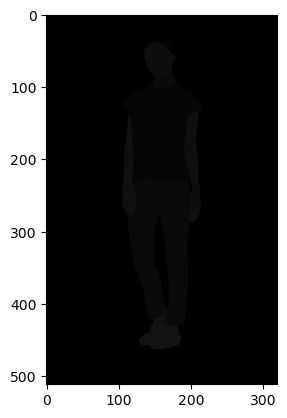

In [56]:
parse = cv2.imread('dataset/image-parse/0VB21E007-T11@9=person_whole_front_label.png')
plt.imshow(parse)

In [57]:
parse_shape = (parse>0).astype(np.float64)
parse_shape.shape, parse_shape[:1]

((512, 320, 3),
 array([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 

In [58]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(3, 3))
parse_shape_erode = cv2.erode(parse_shape, kernel)
kernel, parse_shape_erode.shape, parse_shape_erode[:1]

(array([[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1]], dtype=uint8),
 (512, 320, 3),
 array([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0

In [59]:
rgb = np.array(Image.open('mpv3d_example/'))

PermissionError: [Errno 13] Permission denied: 'results/aligned/'

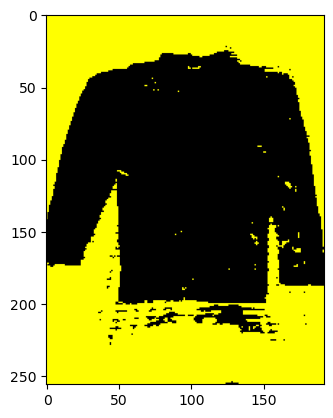

In [14]:
import cv2
import numpy as np
import matplotlib.pyplot as plt 

# Read the image
image = cv2.imread('redcloth.jpg')

# Convert the image to grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply thresholding
_, binary_mask = cv2.threshold(gray_image, 97, 255, cv2.THRESH_BINARY)

# Create a mask for the yellow background
yellow_background = np.zeros_like(image, dtype=np.uint8)
yellow_background[:] = (0, 255, 255)  # Set the color to yellow (BGR format)

# Replace black pixels in the binary mask with yellow
result_mask = cv2.bitwise_or(yellow_background, yellow_background, mask=binary_mask)

plt.imshow(cv2.cvtColor(result_mask, cv2.COLOR_BGR2RGB))
plt.show()


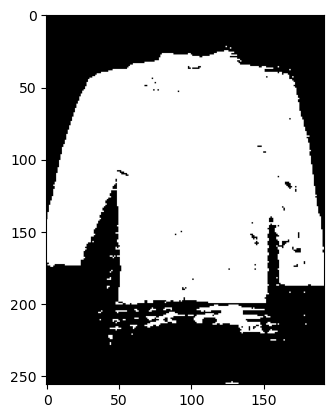

In [15]:
# Define the lower and upper bounds for yellow (background) in BGR format
lower_yellow = np.array([0, 200, 200], dtype=np.uint8)
upper_yellow = np.array([100, 255, 255], dtype=np.uint8)

# Create masks for yellow (background) and non-yellow (cloth)
yellow_mask = cv2.inRange(result_mask, lower_yellow, upper_yellow)
cloth_mask = cv2.bitwise_not(yellow_mask)

# Convert the cloth to white
result_image = result_mask.copy()
result_image[cloth_mask > 0] = [255, 255, 255]

# Convert the background except cloth to black
result_image[yellow_mask > 0] = [0, 0, 0]

plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
plt.show()

In [16]:
# Save the result image to a folder
cv2.imwrite('result_image.jpg', result_image)

True

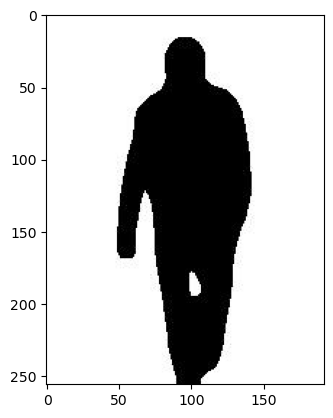

In [3]:
import matplotlib.pyplot as plt 
import cv2 

img = cv2.imread('ryan.jpg', 1)
plt.imshow(img)

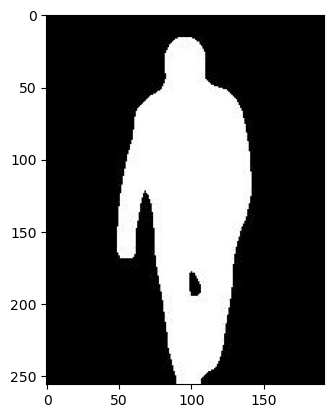

In [4]:
img = 255 - img 
plt.imshow(img)

In [5]:
cv2.imwrite('ryan.png', img)

True

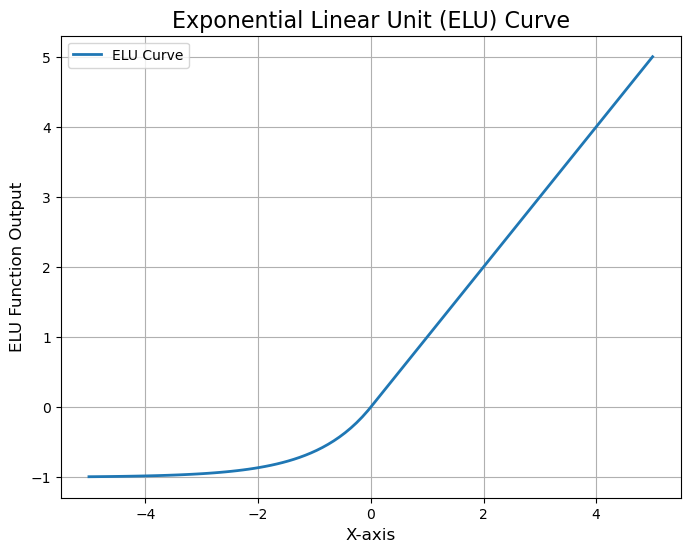

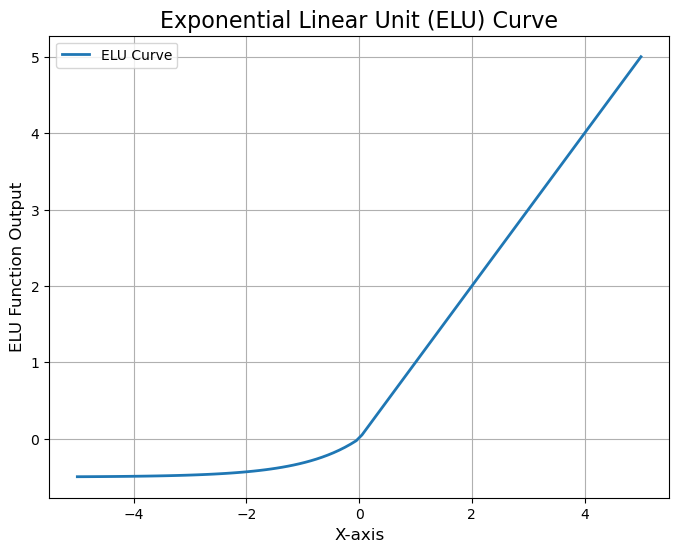

In [30]:
import matplotlib.pyplot as plt
import numpy as np

def plot_elu_curve(alpha=1.0, label_num=1):
    x = np.linspace(-5, 5, 100)  # Generating x values

    # ELU function
    y = np.where(x >= 0, x, alpha * (np.exp(x) - 1))

    # Plotting the curve
    plt.figure(figsize=(8, 6))
    plt.plot(x, y, label=f'ELU Curve', linewidth=2)

    plt.title('Exponential Linear Unit (ELU) Curve', fontsize=16)
    plt.xlabel('X-axis', fontsize=12)
    plt.ylabel('ELU Function Output', fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage:
plot_elu_curve(alpha=1.0, label_num=1)
plot_elu_curve(alpha=0.5, label_num=2)


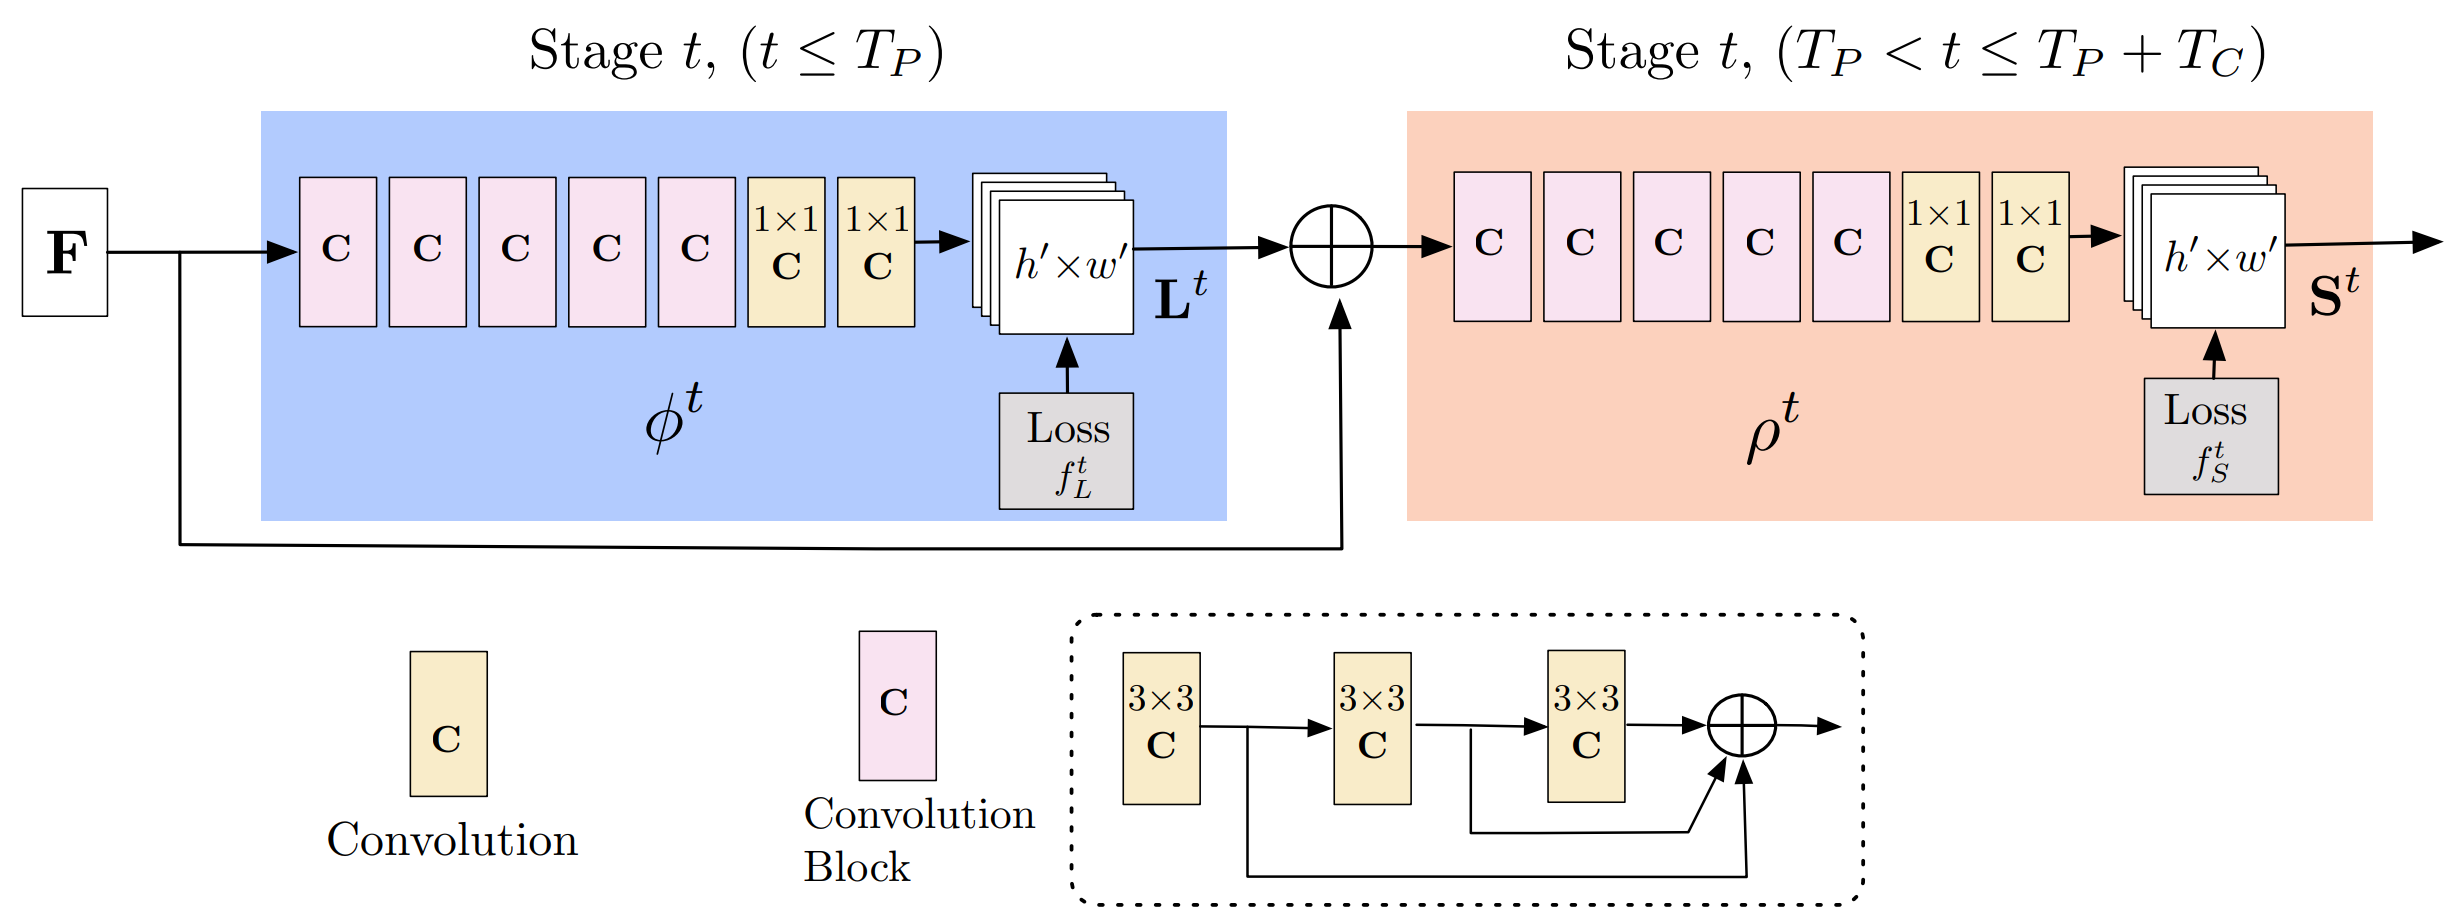

In [36]:
open_pose = Image.open('OpenPose4k.png')
open_pose

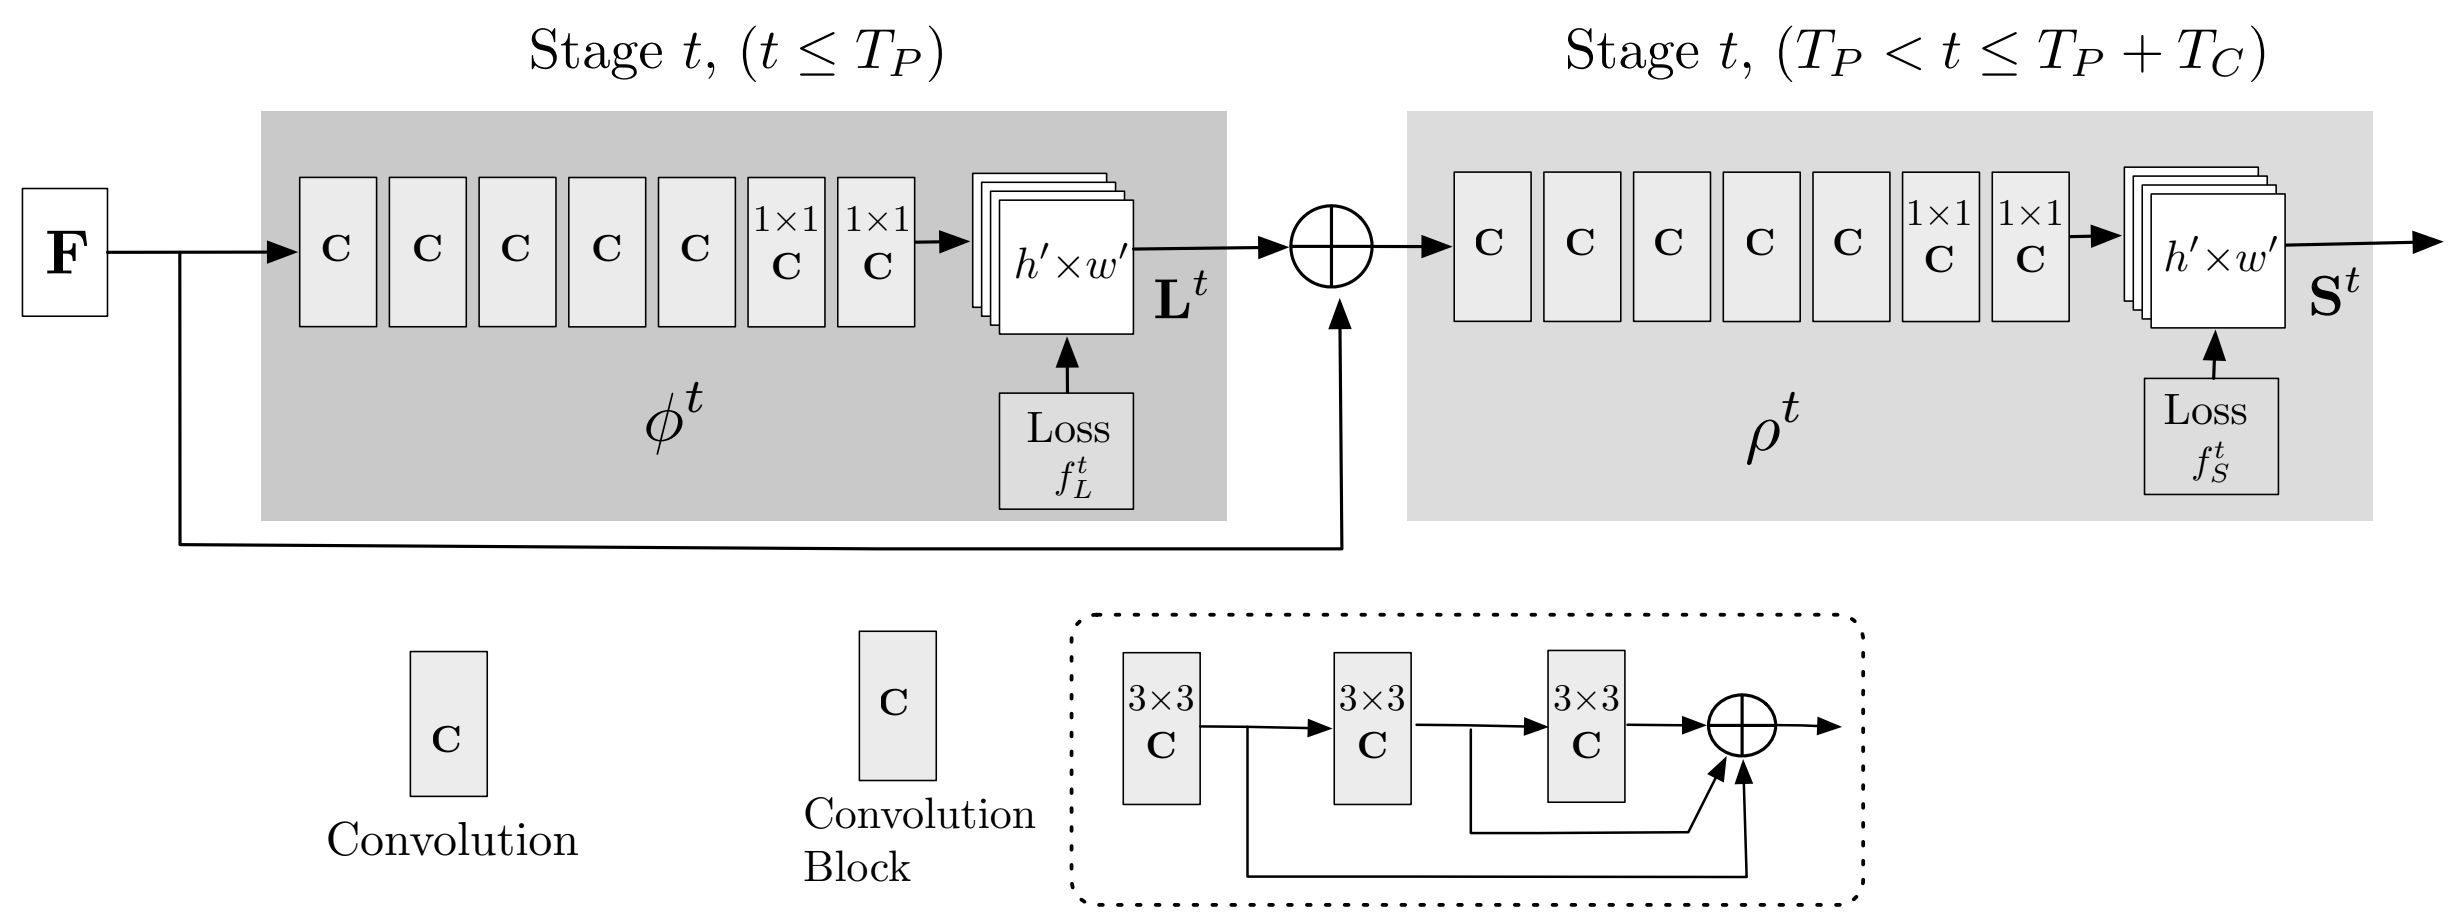

In [37]:
img = open_pose.convert('L')
img 

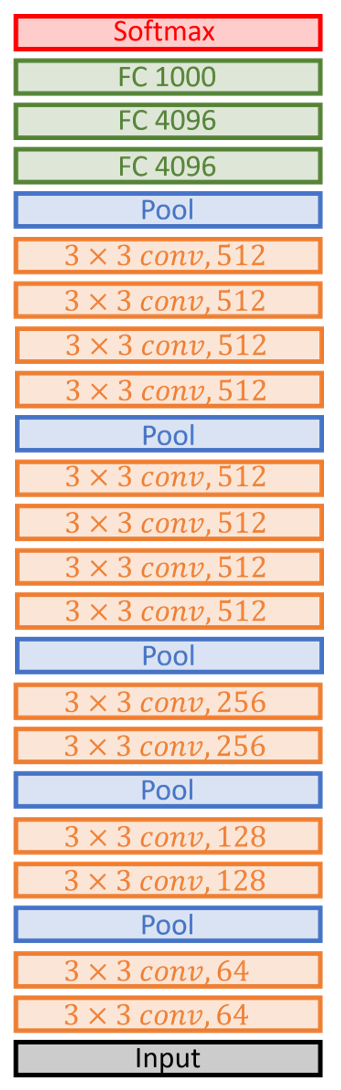

In [4]:
from PIL import Image 
vgg = Image.open('V.png')
vgg 

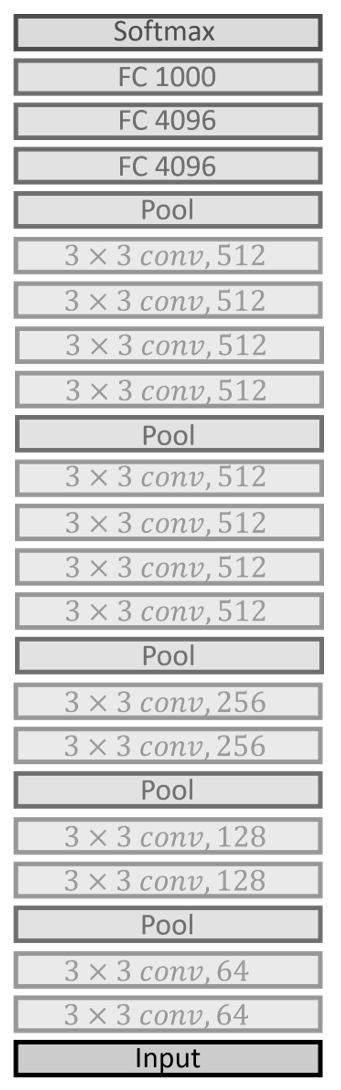

In [5]:
img = vgg.convert('L')
img 